In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.MNIST(root='./data',train=True,transform=transform,download=True)
test_data = datasets.MNIST(root='./root',train=False,download=True,transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 17.3MB/s]


In [3]:
train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,shuffle=False,batch_size=32)

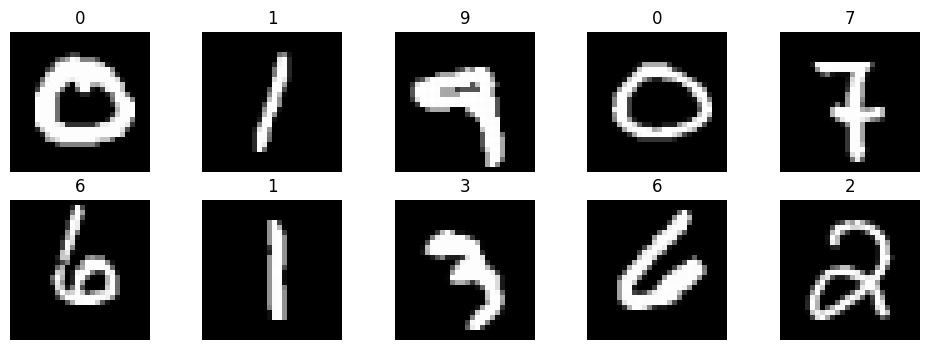

In [4]:
for images, labels in train_loader:

    resize = transforms.Resize((28, 28))

    plt.figure(figsize=(12, 4))

    for i in range(10):
        img = resize(images[i])
        img = img.squeeze().numpy()

        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(labels[i].item())
        plt.axis('off')

    plt.show()
    break


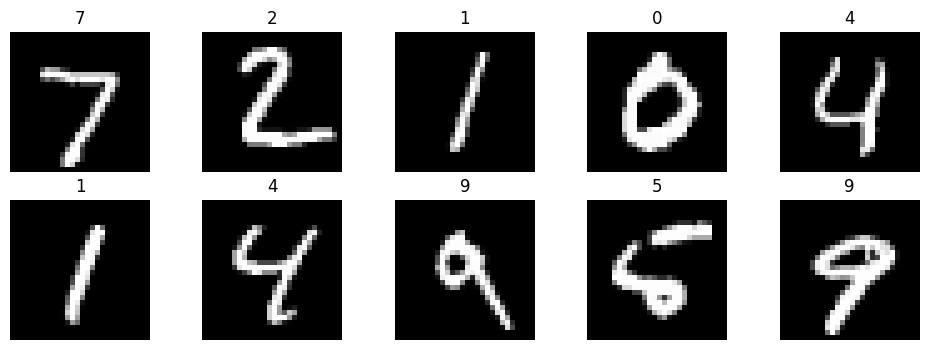

In [5]:
for image ,lable in test_loader:
  resize = transforms.Resize((28,28))

  plt.figure(figsize=(12,4))

  for i in range(10):
    img = resize(image[i])
    img = img.squeeze().numpy()
    plt.subplot(2,5,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(lable[i].item())
    plt.axis('off')

  break


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim=28, hidden1=128, hidden2=96, latent_dim=64):
        super(Encoder, self).__init__()

        self.lstm1 = nn.LSTM(input_dim, hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden1, hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(hidden2, latent_dim, batch_first=True)

    def forward(self, x):
        # x: (batch, seq_len=28, features=28)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        # latent vector is final hidden of timestep 28 → shape (batch, latent)
        latent = x[:, -1, :]
        return latent


In [7]:
class Decoder(nn.Module):
    def __init__(self, seq_len=28, latent_dim=64, hidden1=64, hidden2=96, hidden3=128, output_dim=28):
        super(Decoder, self).__init__()

        self.seq_len = seq_len

        self.lstm1 = nn.LSTM(latent_dim, hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden1, hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(hidden2, hidden3, batch_first=True)

        self.output_layer = nn.Linear(hidden3, output_dim)

    def forward(self, latent):
        # Repeat latent vector for each timestep → (batch, seq_len, latent_dim)
        x = latent.unsqueeze(1).repeat(1, self.seq_len, 1)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)

        # TimeDistributed(Dense)
        out = self.output_layer(x)
        return out


In [8]:
Decoder()

Decoder(
  (lstm1): LSTM(64, 64, batch_first=True)
  (lstm2): LSTM(64, 96, batch_first=True)
  (lstm3): LSTM(96, 128, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=28, bias=True)
)

In [9]:
Encoder()

Encoder(
  (lstm1): LSTM(28, 128, batch_first=True)
  (lstm2): LSTM(128, 96, batch_first=True)
  (lstm3): LSTM(96, 64, batch_first=True)
)

In [10]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self,x):
    latent = self.encoder(x)
    output = self.decoder(latent)
    return output

In [11]:
AutoEncoder()

AutoEncoder(
  (encoder): Encoder(
    (lstm1): LSTM(28, 128, batch_first=True)
    (lstm2): LSTM(128, 96, batch_first=True)
    (lstm3): LSTM(96, 64, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(64, 64, batch_first=True)
    (lstm2): LSTM(64, 96, batch_first=True)
    (lstm3): LSTM(96, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=28, bias=True)
  )
)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


epochs = 10

for epoch in range(epochs):

  for images,_ in train_loader:
    img = images.squeeze(1).to(device)

    optimizer.zero_grad()
    model_output = model(img)
    loss_value = loss(model_output,img)
    loss_value.backward()
    optimizer.step()

  print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_value.item():.4f}")

Epoch [1/10], Loss: 0.0276
Epoch [2/10], Loss: 0.0162
Epoch [3/10], Loss: 0.0104
Epoch [4/10], Loss: 0.0106
Epoch [5/10], Loss: 0.0081
Epoch [6/10], Loss: 0.0081
Epoch [7/10], Loss: 0.0071
Epoch [8/10], Loss: 0.0063
Epoch [9/10], Loss: 0.0066
Epoch [10/10], Loss: 0.0046


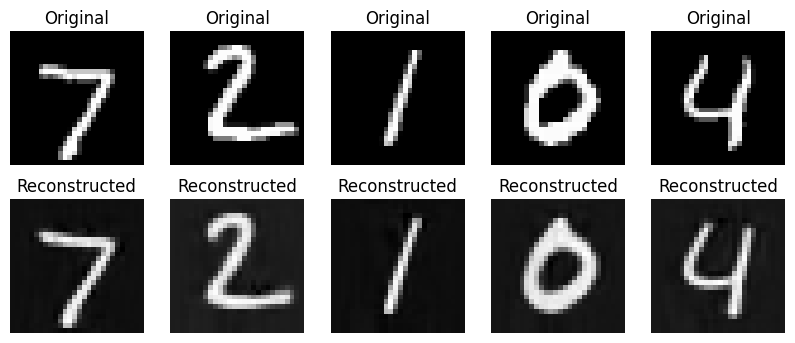

In [13]:
model.eval()


for images, _ in test_loader:

    images = images.squeeze(1)
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)  # (batch, 28, 28)

    # show first 5 images
    plt.figure(figsize=(10, 4))

    for i in range(5):
        # original
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        # reconstructed
        plt.subplot(2, 5, i + 6)
        plt.imshow(outputs[i].cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")

    plt.show()

     # only first batch
    break